In [20]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

import statsmodels.nonparametric.smoothers_lowess as sl

rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

In [2]:
import pysam

In [206]:
bam = pysam.AlignmentFile("/Users/davidangeles/repos/tnseq/aligned/sorted.aligned.bam", "rb")

gff = pd.read_csv('/Users/davidangeles/PA14/ensembl/Pseudomonas_aeruginosa_ucbpp_pa14_gca_000014625.ASM1462v1.51.chromosome.Chromosome.gff',
                  sep='\t', comment='#')
gff.columns = ['Chromosome', 'NaN', 'Type', 'Pos1', 'Pos2', '.', 'Strand', 'Unk', 'FeatureDescription']
gff['Description'] = gff.FeatureDescription.str.split('description=', expand=True)[1].str.split(';', expand=True)[0]
gff['HumanReadableName'] = gff.FeatureDescription.str.split('Name=', expand=True)[1].str.split(';', expand=True)[0]
gff['TxName'] = gff.FeatureDescription.str.split(';', expand=True)[0].str.replace('ID=transcript:', '')

In [580]:
def count_mutants(bam):
    """
    Generate a dictionary of reads that align at a specific
    """
    iter = bam.fetch()
    idx = {}
    for x in iter:
        if x.is_reverse == False:
            try:
                idx[x.reference_start] += 1
            except:
                idx[x.reference_start] = 1
        else:
            try:
                idx[x.reference_end] += 1
            except:
                idx[x.reference_end] = 1
    
    to_remove = []
    for k, v in idx.items():
        if v == 1:
            to_remove += [k]
            
    for k in to_remove:
        idx.pop(k)
    return idx

def correct_muts(idx):
    found = []
    for k in idx.keys():
        try:
            v = idx[k + 1]
            found += [k + 1]
        except:
            continue
    return len(found)

In [581]:
bam = pysam.AlignmentFile("/Users/davidangeles/repos/tnseq/aligned/sorted.aligned.bam", "rb")
idx = count_mutants(bam)
close = correct_muts(idx)
print('To a first approximation, there appear to be around {0:.1e} mutants in this library'.format(len(idx.keys())))
print('There are around {0:.1e} reads with 5\' insertions within 1bp of an upstream insertion'.format(close))
print('Lower bound for mutants: {0:.1e}'.format(len(idx.keys()) - close))
print('There is an insertion every {0} bp on average'.format(int(np.floor(6 * 10 ** 6 / (len(idx.keys()) - close)))))

To a first approximation, there appear to be around 1.6e+05 mutants in this library
There are around 1.3e+04 reads with 5' insertions within 1bp of an upstream insertion
Lower bound for mutants: 1.5e+05
There is an insertion every 40 bp on average


In [442]:
mutants = pd.DataFrame.from_dict(idx, orient='index').reset_index()
mutants.columns = ['Position', 'Frequency']
mutants.sort_values('Position', inplace=True)

mutants['NormFreq'] = mutants.Frequency / mutants.Frequency.sum() * 10 ** 6

bin_size = 500
bins = np.arange(0, mutants.Position.max(), bin_size)

binned = mutants.groupby(pd.cut(mutants.Position, bins)).mean()
binned['Fano'] = mutants.groupby(pd.cut(mutants.Position, bins)).Frequency.apply(lambda x: np.var(x) / np.mean(x))
binned.Position = np.arange(bin_size / 2, mutants.Position.max() - bin_size / 2, bin_size)
binned.fillna(0, inplace=True)
binned.head()

,Position,Frequency,NormFreq,Fano
Position,,,,
"(0, 500]",250.0,18.076923,3.708913,31.731588
"(500, 1000]",750.0,1.000000,0.205174,0.000000
"(1000, 1500]",1250.0,0.000000,0.000000,0.000000
"(1500, 2000]",1750.0,0.000000,0.000000,0.000000
"(2000, 2500]",2250.0,8.250000,1.692685,19.113636


In [377]:
mutants.head()

def lowess(x):
    x['LOWESS'] = sl.lowess(x.Frequency, x.Position, return_sorted=False, it=4, delta=5 * 10 ** 3, frac=.5)

lowess(binned)

(0.0, 6.0)

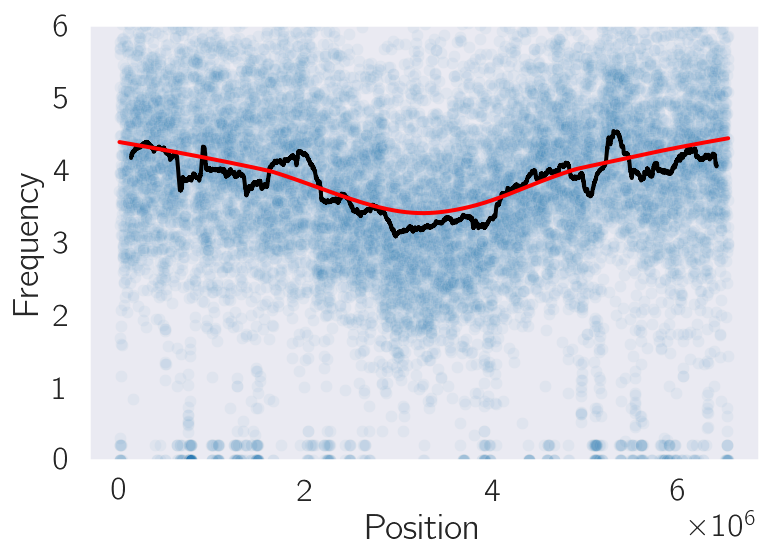

In [380]:
sns.scatterplot(x='Position', y='Frequency', data=binned, alpha=0.05)
plt.plot(binned.Position.rolling(5 * 10 ** 2).mean(),
         binned.Frequency.rolling(5 * 10 ** 2).mean(), color='black')
plt.plot(binned.Position, binned.LOWESS, color='red')
plt.ylim(0, 6)

(1e-05, 1000)

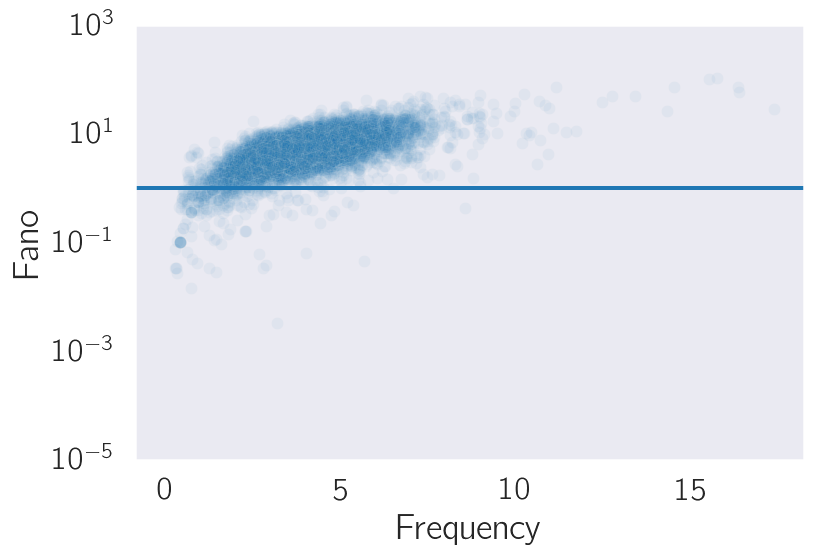

In [381]:
sns.scatterplot(x='Frequency', y='Fano', data=binned, alpha=0.05)
plt.axhline(1)
plt.yscale('log')
plt.ylim(10 ** -5 , 10 ** 3)

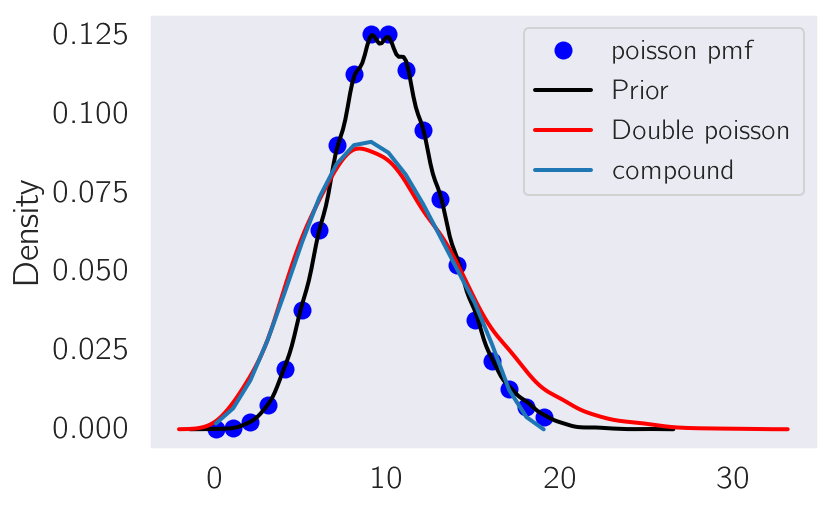

In [203]:
def factorial(x):
    if x == 0:
        return 1
    else:
        return x * factorial(x - 1)

def poisson(k, lam):
    return np.exp(-lam) * lam ** k / scipy.special.factorial(k)
    
x = np.arange(0, 20)
plt.plot(x, scipy.stats.poisson.pmf(x, 10), 'bo', ms=8, label='poisson pmf')
y = np.random.poisson(10, 10 ** 4)
sns.kdeplot(y, color='black', label='Prior')
sns.kdeplot(np.random.poisson(y), color='red', label='Double poisson')

compound = lambda x, lam: poisson(x, lam) * poisson(lam, 10)

p_lamk = np.array([compound(x, i) for i in range(30)])
plt.plot(x, p_lamk.sum(axis=0), label='compound')
plt.legend()

In [182]:
import scipy

In [443]:
gff['Pos1,Pos2'] = gff.apply(lambda x: (x.Pos1, x.Pos2 - 3), axis=1)

In [444]:
AvgPos = gff[gff.Type == 'mRNA'][['Pos1', 'Pos2']].apply(np.mean, axis=1)
Size = gff[gff.Type == 'mRNA'][['Pos1', 'Pos2']].apply(lambda x: np.abs(x.Pos1 - x.Pos2), axis=1)
Name = gff[gff.Type == 'mRNA'].HumanReadableName

bins = pd.IntervalIndex.from_tuples(gff[gff.Type == 'mRNA']['Pos1,Pos2'].values)
overlaps = np.array([bins.overlaps(x).sum() for x in bins])
bins = bins[overlaps == 1]

genes = mutants.groupby(pd.cut(mutants.Position, bins)).Frequency.mean()
genes = pd.DataFrame(genes)
genes['TnMutants'] = mutants.groupby(pd.cut(mutants.Position, bins)).Frequency.count()
genes['TotalFreq'] = mutants.groupby(pd.cut(mutants.Position, bins)).Frequency.sum()
genes['Var'] = mutants.groupby(pd.cut(mutants.Position, bins)).Frequency.var()

genes.reset_index(inplace=True)
genes.columns = ['BinnedPos', 'Frequency', 'TnMutants', 'TotalFreq', 'Var']

genes['Position'] = AvgPos.values[overlaps == 1]
genes['Size'] = Size.values[overlaps == 1]
genes['HRName'] = Name.values[overlaps == 1]

genes['TnInsKbp'] = genes.TnMutants / genes.Size * 10 ** 3
genes['log1pAvgFreq'] = genes.Frequency.apply(np.log1p)
genes['log1pTotFreq'] = genes.TotalFreq.apply(np.log1p)

In [445]:
genes

,BinnedPos,Frequency,TnMutants,TotalFreq,Var,Position,Size,HRName,TnInsKbp,log1pAvgFreq,log1pTotFreq
0,"(483, 2024]",1.000000,1,1,NaN,1255.0,1544,dnaA-1,0.647668,0.693147,0.693147
1,"(2056, 3156]",3.333333,3,10,16.333333,2607.5,1103,dnaN-1,2.719855,1.466337,2.397895
2,"(3169, 4275]",22.272727,22,490,587.636364,3723.5,1109,recF-1,19.837692,3.147282,6.196444
3,"(4275, 6692]",1.500000,2,3,0.500000,5485.0,2420,gyrB-1,0.826446,0.916291,1.386294
4,"(7018, 7788]",13.291667,24,319,238.911232,7404.5,773,None,31.047865,2.659677,5.768321
...,...,...,...,...,...,...,...,...,...,...,...
5310,"(6530561, 6532450]",15.519231,52,807,257.117270,6531507.0,1892,gidA-1,27.484144,2.804525,6.694562
5311,"(6532927, 6533307]",16.818182,11,185,265.563636,6533118.5,383,None,28.720627,2.880219,5.225747
5312,"(6533634, 6534998]",17.714286,35,620,573.033613,6534317.5,1367,thdF-1,25.603511,2.929287,6.431331
5313,"(6535072, 6536805]",23.000000,2,46,968.000000,6535940.0,1736,yidC-1,1.152074,3.178054,3.850148


/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,BinnedPos,Frequency,TnMutants,TotalFreq,Var,Position,Size,HRName,TnInsKbp,log1pAvgFreq,log1pTotFreq,Delta
664,"(796493, 798202]",12.708348,198,2516.252851,1050.336713,797349.0,1712,pchH-1,115.654206,2.618005,7.830923,0.826198
1603,"(1935570, 1935902]",5.483273,40,219.330911,55.711773,1935737.5,335,None,119.402985,1.869225,5.395131,0.069161
1570,"(1893771, 1894082]",6.695149,38,254.415650,166.750226,1893928.0,314,sugE-1,121.019108,2.040590,5.542892,0.236814
4355,"(5346464, 5346733]",5.608087,33,185.066868,55.250561,5346600.0,272,None,121.323529,1.888294,5.226106,0.083819
2581,"(3176984, 3177355]",7.644283,66,504.522649,176.229904,3177171.0,374,None,176.470588,2.156898,6.225593,0.229435


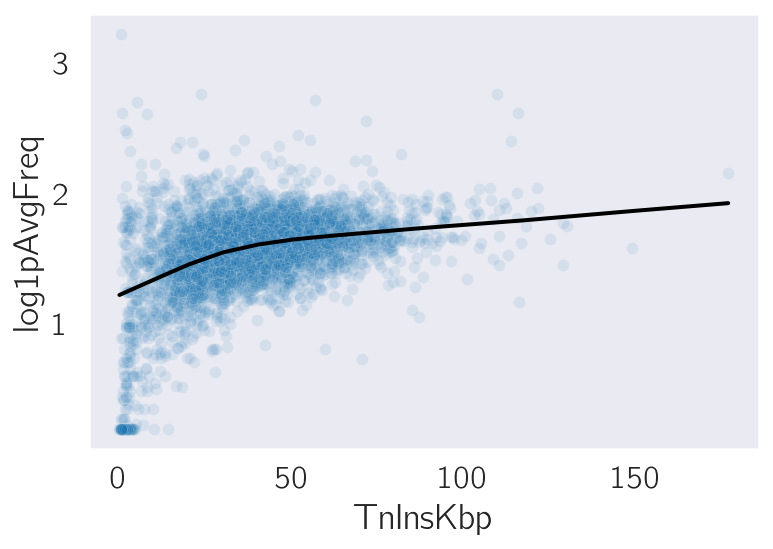

In [385]:
y = 'log1pAvgFreq'
sns.scatterplot('TnInsKbp', y, data=genes, alpha=0.1)
lowess = sl.lowess(genes.sort_values('TnInsKbp')[y], genes.sort_values('TnInsKbp').TnInsKbp,
                   return_sorted=False, it=4, delta=10, frac=.66)
plt.plot(genes.sort_values('TnInsKbp').TnInsKbp, lowess, color='black')

genes = genes.sort_values('TnInsKbp')
genes['Delta'] = genes.log1pAvgFreq - lowess
genes = genes.sort_values(['TnInsKbp', 'Delta'])
genes[genes.Delta > 0].tail(5)

/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


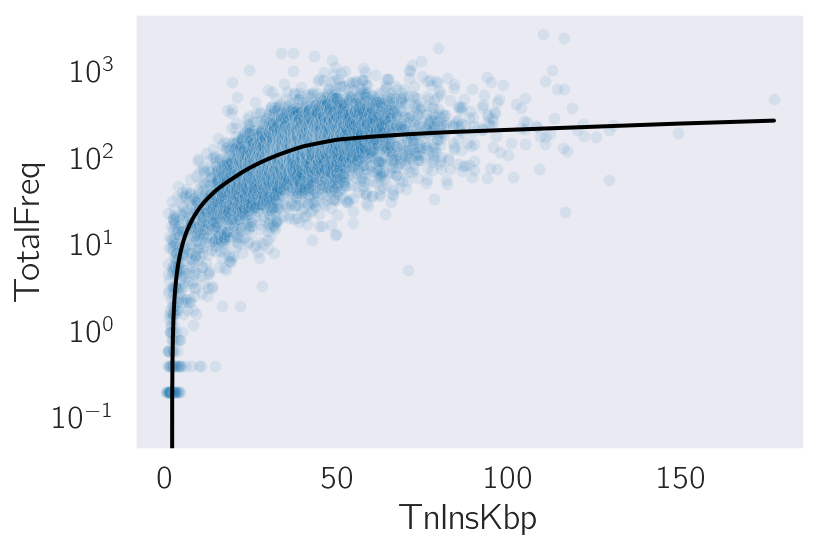

In [396]:
y = 'TotalFreq'
sns.scatterplot('TnInsKbp', y, data=genes, alpha=0.1)
lowess = sl.lowess(genes.sort_values('TnInsKbp')[y], genes.sort_values('TnInsKbp').TnInsKbp,
                   return_sorted=False, it=4, delta=10, frac=.66)
plt.plot(genes.sort_values('TnInsKbp').TnInsKbp, lowess, color='black')
plt.yscale('log')

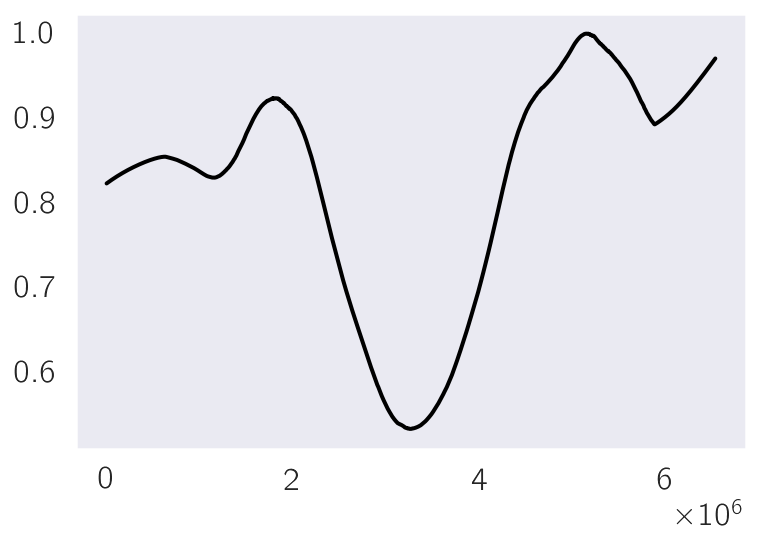

In [387]:
x = 'Position'
y = 'TnInsKbp'
# sns.scatterplot(x, y, data=genes)
lowess = sl.lowess(genes.sort_values(x)[y], genes.sort_values(x)[x],
                   return_sorted=False, it=4, delta=500, frac=.2)
plt.plot(genes.sort_values(x)[x], lowess / lowess.max(), color='black')


0.8651035917631978


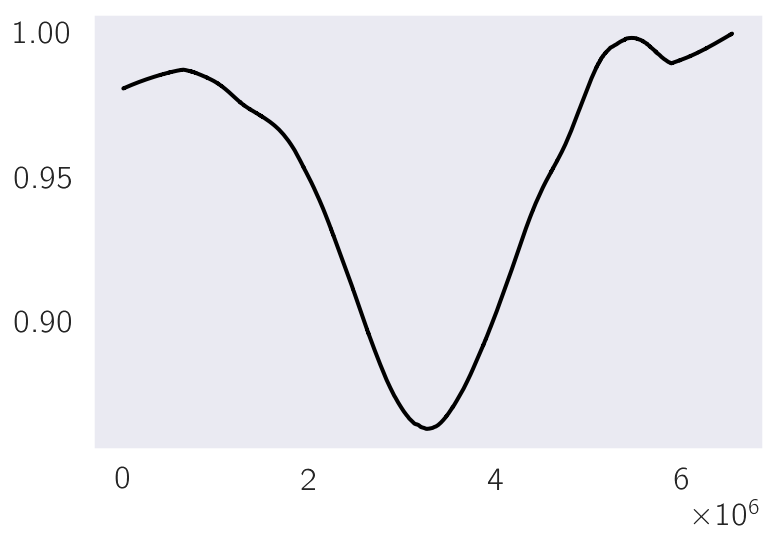

In [393]:
x = 'Position'
y = 'log1pAvgFreq'
# sns.scatterplot(x, y, data=genes)
lowess = sl.lowess(genes.sort_values(x)[y], genes.sort_values(x)[x],
                   return_sorted=False, it=4, delta=10, frac=.2)
plt.plot(genes.sort_values(x)[x], lowess / lowess[~np.isnan(lowess)].max(), color='black')
print(lowess[~np.isnan(lowess)].min() / np.percentile(lowess[~np.isnan(lowess)], 95))

0.8342668035972656


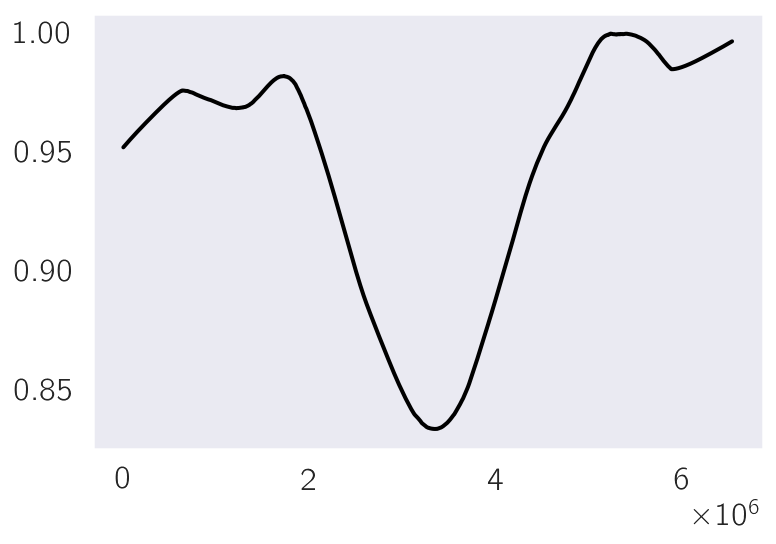

In [394]:
x = 'Position'
y = 'log1pTotFreq'
# sns.scatterplot(x, y, data=genes)
lowess = sl.lowess(genes.sort_values(x)[y], genes.sort_values(x)[x],
                   return_sorted=False, it=4, delta=10, frac=.2)
plt.plot(genes.sort_values(x)[x], lowess / lowess.max(), color='black')
print(lowess[~np.isnan(lowess)].min() / np.percentile(lowess[~np.isnan(lowess)], 95))

In [529]:
def size(x):
    try:
        delta = x.max() - x.min()
    except:
        return np.nan
    return delta

mutants['PerBinSum'] = mutants.groupby(pd.cut(mutants.Position, bins)).Frequency.transform(np.sum)
mutants['PerBinCount'] = mutants.groupby(pd.cut(mutants.Position, bins)).Frequency.transform('count')

subset = mutants.dropna().copy()
subset = subset[subset.PerBinCount > 7]
subset['AlleleFreq'] = subset.Frequency / subset.PerBinSum
subset['BinSize'] = subset.groupby(pd.cut(subset.Position, bins)).Position.transform(size)
subset['PerBinCountPerKbp'] = subset.PerBinCount / subset.BinSize * 10 ** 3
subset['OneAbove'] = subset.groupby(pd.cut(subset.Position, bins)).AlleleFreq.transform(lambda x: x.min() >  3 * 10 ** -3)
subset['BinPosition'] = subset.groupby(pd.cut(subset.Position, bins)).Position.transform(lambda x: (x - x.min()) / (x.max() - x.min()))

In [530]:
subset.sort_values('Position').head()

,Position,Frequency,NormFreq,PerBinSum,PerBinCount,AlleleFreq,BinSize,PerBinCountPerKbp,OneAbove,BinPosition
23,3231,1,0.205174,490.0,22.0,0.002041,894,24.608501,False,0.000000
22,3233,56,11.489739,490.0,22.0,0.114286,894,24.608501,False,0.002237
24,3235,14,2.872435,490.0,22.0,0.028571,894,24.608501,False,0.004474
27,3270,21,4.308652,490.0,22.0,0.042857,894,24.608501,False,0.043624
25,3279,33,6.770739,490.0,22.0,0.067347,894,24.608501,False,0.053691


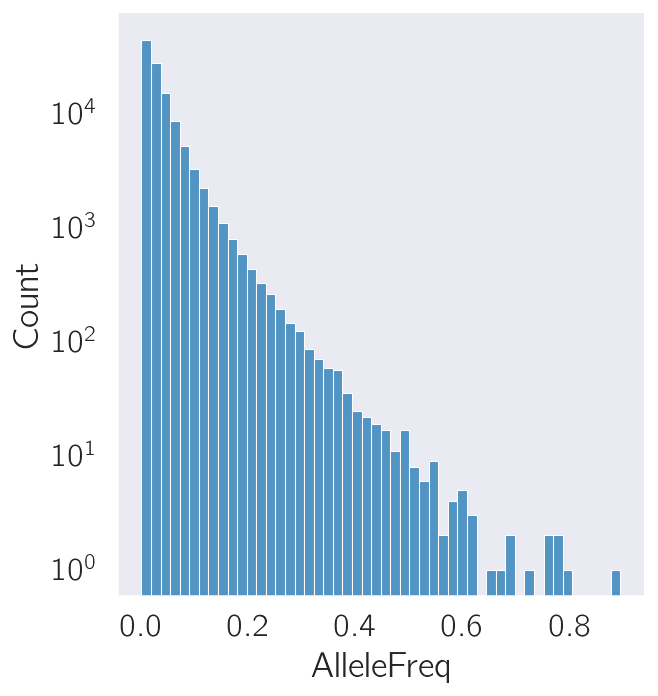

In [549]:
sns.displot(subset.AlleleFreq[subset.Frequency > 3], bins=50)
# sns.displot(subset.AlleleFreq, bins=50)
plt.yscale('log')

47.44187100309293

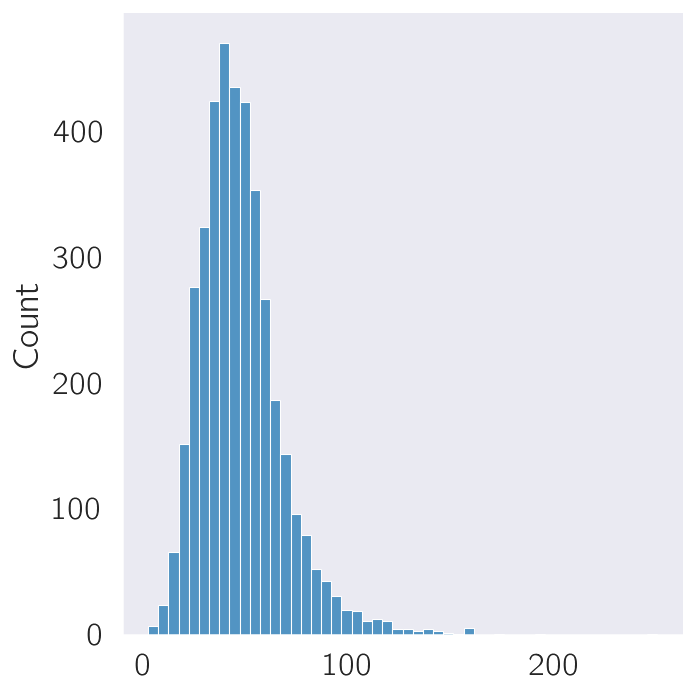

In [550]:
sns.displot(subset.PerBinCountPerKbp[subset.Frequency > 3].unique(), bins=50)
subset.PerBinCountPerKbp.unique().mean()

/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


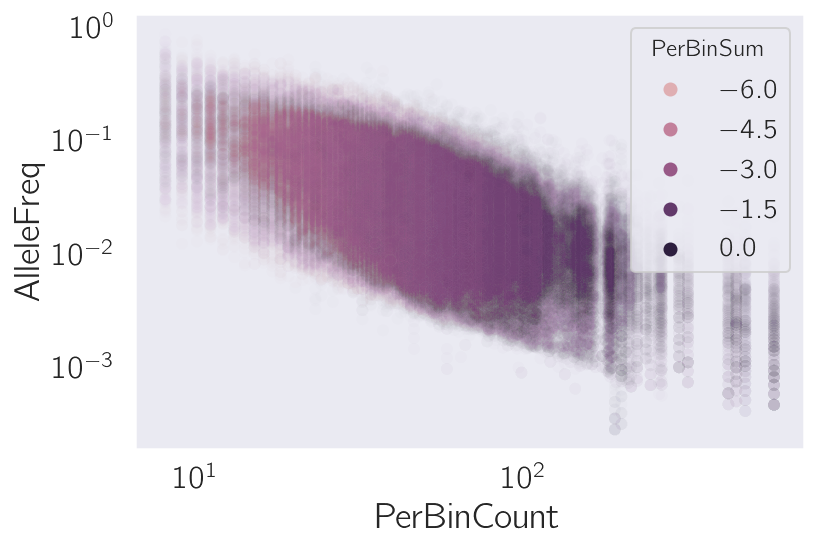

In [552]:
colors = subset.PerBinSum / subset.PerBinSum.max()
cond = subset.Frequency > 3
sns.scatterplot('PerBinCount', 'AlleleFreq', data=subset[cond], hue=colors.apply(np.log), alpha=0.01)
plt.yscale('log')
plt.xscale('log')

/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


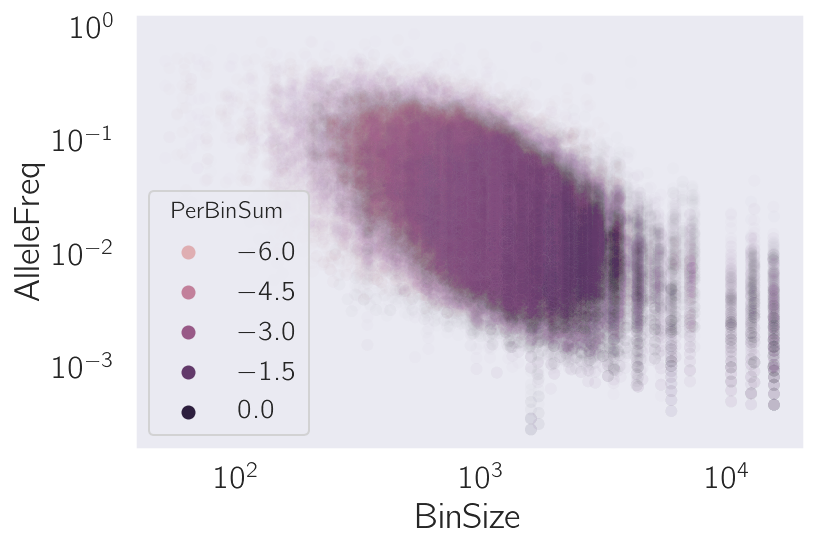

In [543]:
colors = subset.PerBinSum / subset.PerBinSum.max()
cond = (subset.Frequency > 3)
sns.scatterplot('BinSize', 'AlleleFreq', data=subset[cond], hue=colors.apply(np.log), alpha=0.01)
plt.yscale('log')
plt.xscale('log')

/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


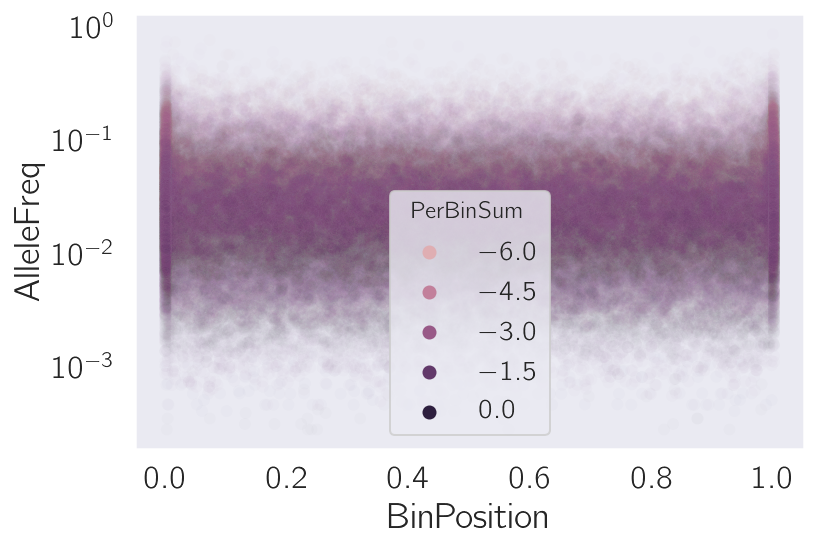

In [545]:
colors = subset.PerBinSum / subset.PerBinSum.max()
sns.scatterplot('BinPosition', 'AlleleFreq', data=subset[cond], hue=colors.apply(np.log), alpha=0.01)
plt.yscale('log')
# plt.xscale('log')
# plt.xlim(10 ** -5, 10)

Text(0.5, 8.959999999999997, '$\\log(\\frac{r_i}{\\sum_i r_i})$')

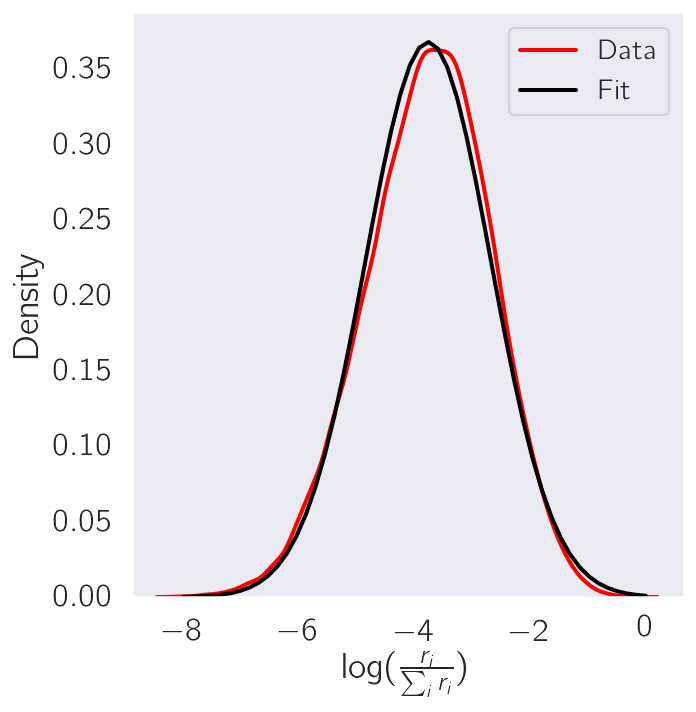

In [569]:
mean = subset[cond].AlleleFreq.apply(np.log).mean()
var = subset[cond].AlleleFreq.apply(np.log).std()

x = np.linspace(-8, 0)
sns.displot(subset[cond].AlleleFreq.apply(np.log), kind='kde', color='red', label='Data')
plt.plot(x, scipy.stats.norm.pdf(x, loc=mean, scale=var), color='black', label='Fit')
plt.legend()
plt.xlabel(r'$\log(\frac{r_i}{\sum_i r_i})$')

In [570]:
subset[cond].head()

,Position,Frequency,NormFreq,PerBinSum,PerBinCount,AlleleFreq,BinSize,PerBinCountPerKbp,OneAbove,BinPosition
22,3233,56,11.489739,490.0,22.0,0.114286,894,24.608501,False,0.002237
24,3235,14,2.872435,490.0,22.0,0.028571,894,24.608501,False,0.004474
27,3270,21,4.308652,490.0,22.0,0.042857,894,24.608501,False,0.043624
25,3279,33,6.770739,490.0,22.0,0.067347,894,24.608501,False,0.053691
26,3284,14,2.872435,490.0,22.0,0.028571,894,24.608501,False,0.059284


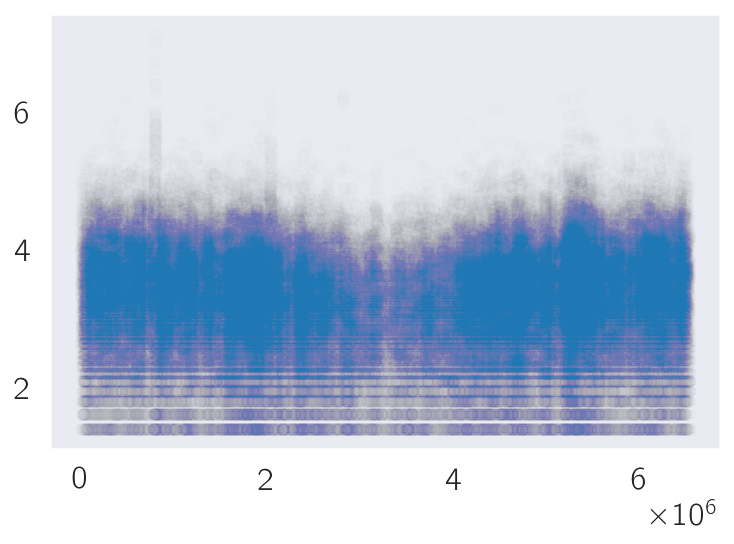

In [575]:
plt.scatter(subset[cond].Position, subset[cond].Frequency.apply(np.log), alpha=0.005)

In [576]:
subset.shape

(194264, 10)